# Retina Image Segmentation and Saving Results

This notebook loads a trained patch-based classifier, segments a few images from the dataset, and stores the predicted segmentation maps in variables for later visualization or analysis.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
from DLModel import DLModel
from torchvision import transforms as T

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths
data_dir = 'images/pictures/'
mask_dir = 'images/mask/'
label_dir = 'images/manual/'

# Model loading
model = DLModel()
model.load_state_dict(torch.load('model_final.pth', map_location=device))
model.to(device)
model.eval()

C:\Users\Gienon\AppData\Local\Temp\ipykernel_19900\1854517891.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_final.pth', map_lo

DLModel(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AdaptiveMaxPool2d(output_size=(8, 8))
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=8192, out_features=512, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.3, inplace=False)
    (18):

In [2]:
def segment_image_with_model(image_path, mask_path, model, device='cpu', patch_size=27, batch_size=128):
    """
    For each pixel in the image, if it is within the mask and a full patch can be extracted,
    immediately classify the patch and assign the result to the output map.
    This is more memory-efficient and processes patches on the go.
    """
    image = np.array(Image.open(image_path).convert('RGB'))
    mask = np.array(Image.open(mask_path))
    # Convert mask to single channel if it's a 3-channel image
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask = mask[:, :, 0]  # Take only the first channel

    H, W = mask.shape
    pad = patch_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    pred_map = np.zeros((H, W), dtype=np.uint8)
    patch_transform = T.ToTensor()
    batch = []
    positions = []

    with torch.no_grad():
        for y in range(H):
            for x in range(W):
                if mask[y, x] > 0:
                    y_pad, x_pad = y + pad, x + pad
                    # Check if the patch is fully within the padded image
                    if (y_pad - pad >= 0 and y_pad + pad < H + 2 * pad and
                        x_pad - pad >= 0 and x_pad + pad < W + 2 * pad):
                        patch = padded_image[y_pad - pad:y_pad + pad + 1, x_pad - pad:x_pad + pad + 1, :]
                        patch_tensor = patch_transform(patch)
                        batch.append(patch_tensor)
                        positions.append((y, x))
                        if len(batch) == batch_size:
                            batch_tensor = torch.stack(batch).to(device)
                            outputs = model(batch_tensor)
                            _, preds = torch.max(outputs, 1)
                            preds = preds.cpu().numpy()
                            for i, (yy, xx) in enumerate(positions):
                                pred_map[yy, xx] = preds[i]
                            batch = []
                            positions = []
        # Process any remaining patches
        if batch:
            batch_tensor = torch.stack(batch).to(device)
            outputs = model(batch_tensor)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            for i, (yy, xx) in enumerate(positions):
                pred_map[yy, xx] = preds[i]
    return pred_map

In [3]:
# List a few images to segment
image_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.jpg')])[:3]  # Change number as needed

segmentation_results = {}

for fname in image_files:
    base = fname.rsplit('.', 1)[0]
    image_path = os.path.join(data_dir, fname)
    mask_path = os.path.join(mask_dir, f"{base}_mask.tif")
    label_path = os.path.join(label_dir, f"{base}.tif")
    if not (os.path.exists(mask_path) and os.path.exists(label_path)):
        print(f"Mask or label not found for {fname}, skipping.")
        continue
    print(f"Segmenting {fname}...")
    pred_map = segment_image_with_model(image_path, mask_path, model, device=device)
    segmentation_results[base] = {
        "pred_map": pred_map,
        "image_path": image_path,
        "mask_path": mask_path,
        "label_path": label_path
    }
print("Segmentation complete. Results are stored in the 'segmentation_results' dictionary.")

Segmenting 01_dr.JPG...


KeyboardInterrupt: 

In [ ]:
from PIL import Image
from Util.Visualisation import Visualisation

import matplotlib.pyplot as plt

# Ensure there are segmentation results to display
if not segmentation_results:
    print("No segmentation results available to display.")
else:
    # Determine the number of images to display
    num_images = len(segmentation_results)

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(num_images, 4, figsize=(16, 4 * num_images))  # Adjust figure size as needed

    # Loop through the segmentation results and display the images
    for i, (base, result) in enumerate(segmentation_results.items()):
        image_path = result["image_path"]
        mask_path = result["mask_path"]
        pred_map = result["pred_map"]

        # Load the original image and mask
        image = Image.open(image_path)
        mask = Image.open(mask_path)

        # Create the difference map
        diff_map = Visualisation.create_diffmap(np.array(mask), pred_map)

        # Determine the correct index for the subplots
        if num_images == 1:
            ax_image, ax_mask, ax_pred, ax_diff = axes
        else:
            ax_image, ax_mask, ax_pred, ax_diff = axes[i]

        # Display the original image
        ax_image.imshow(image)
        ax_image.set_title(f"{base}\nOriginal Image")
        ax_image.axis('off')

        # Display the ground truth mask
        ax_mask.imshow(mask, cmap='gray')
        ax_mask.set_title(f"{base}\nGround Truth Mask")
        ax_mask.axis('off')

        # Display the predicted segmentation map
        ax_pred.imshow(pred_map, cmap='gray')
        ax_pred.set_title(f"{base}\nPredicted Segmentation")
        ax_pred.axis('off')

        # Display the difference map
        ax_diff.imshow(diff_map)
        ax_diff.set_title(f"{base}\nDifference Map")
        ax_diff.axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

No segmentation results available to display.


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
from DLModelConv import UNetSmall
from Util.Visualisation import Visualisation
import matplotlib.pyplot as plt

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths
data_dir = 'images/pictures/'
mask_dir = 'images/mask/'
label_dir = 'images/manual/'
model_weights = 'model_final_conv.pth'

# Model loading
model = UNetSmall(in_channels=3, num_classes=2)
model.load_state_dict(torch.load(model_weights, map_location=device))
model.to(device)
model.eval()

# Image transform (must match training, including resize)
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

C:\Users\Gienon\AppData\Local\Temp\ipykernel_24416\1635751867.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights, map_locati

In [ ]:
# Helper: load and preprocess image, mask, label
def load_image_mask_label(base, img_exts=('.jpg', '.jpeg', '.tif', '.tiff', '.png')):
    # Find image file
    for ext in img_exts:
        img_path = os.path.join(data_dir, base + ext)
        if os.path.exists(img_path):
            break
    else:
        raise FileNotFoundError(f"No image found for base {base}")
    mask_path = os.path.join(mask_dir, base + "_mask.tif")
    label_path = os.path.join(label_dir, base + ".tif")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"No mask found for base {base}")
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"No label found for base {base}")
    # Load and preprocess
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    label = Image.open(label_path)
    image_tensor = img_transform(image).unsqueeze(0)  # (1, 3, H, W)
    mask = mask.resize((256, 256), resample=Image.NEAREST)
    label = label.resize((256, 256), resample=Image.NEAREST)
    mask_np = np.array(mask)
    label_np = np.array(label)
    if len(mask_np.shape) == 3:
        mask_np = mask_np[:, :, 0]
    if len(label_np.shape) == 3:
        label_np = label_np[:, :, 0]
    return image, image_tensor, mask_np, label_np

In [ ]:
# Segment and visualize a few images
image_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.tif', '.tiff', '.png'))])[:3]
segmentation_results = {}

for fname in image_files:
    base = os.path.splitext(fname)[0]
    try:
        image, image_tensor, mask_np, label_np = load_image_mask_label(base)
    except FileNotFoundError as e:
        print(e)
        continue
    with torch.no_grad():
        output = model(image_tensor.to(device))  # (1, 2, H, W)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # (H, W)
    # Only keep predictions within the mask
    pred_masked = np.zeros_like(pred)
    pred_masked[mask_np > 0] = pred[mask_np > 0]
    segmentation_results[base] = {
        "image": image,
        "mask": mask_np,
        "label": label_np,
        "pred": pred_masked
    }
print("Segmentation complete. Results are stored in the 'segmentation_results' dictionary.")

Segmentation complete. Results are stored in the 'segmentation_results' dictionary.


In [ ]:
# Debug and improve segmentation results
import torch.nn.functional as F

# Segment and visualize a few images with improved post-processing
image_files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.tif', '.tiff', '.png'))])[:3]
segmentation_results = {}

for fname in image_files:
    base = os.path.splitext(fname)[0]
    try:
        image, image_tensor, mask_np, label_np = load_image_mask_label(base)
    except FileNotFoundError as e:
        print(e)
        continue
    
    with torch.no_grad():
        output = model(image_tensor.to(device))  # (1, 2, H, W)
        
        # Debug: check output shape and values
        print(f"Processing {base}:")
        print(f"  Output shape: {output.shape}")
        print(f"  Output range: [{output.min().item():.3f}, {output.max().item():.3f}]")
        
        # Apply softmax to convert logits to probabilities
        probs = F.softmax(output, dim=1)  # (1, 2, H, W)
        vessel_prob = probs[0, 1].cpu().numpy()  # Get vessel probability map
        
        # Method 1: Use probability threshold
        threshold = 0.5
        pred_thresh = (vessel_prob > threshold).astype(np.uint8)
        
        # Method 2: Use argmax (your original method)
        pred_argmax = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # (H, W)
        
        print(f"  Vessel probability range: [{vessel_prob.min():.3f}, {vessel_prob.max():.3f}]")
        print(f"  Pixels classified as vessel (argmax): {np.sum(pred_argmax == 1)}")
        print(f"  Pixels classified as vessel (threshold): {np.sum(pred_thresh == 1)}")
        print(f"  Total valid pixels in mask: {np.sum(mask_np > 0)}")
        print()
    
    # Only keep predictions within the mask
    pred_thresh_masked = np.zeros_like(pred_thresh)
    pred_thresh_masked[mask_np > 0] = pred_thresh[mask_np > 0]
    
    pred_argmax_masked = np.zeros_like(pred_argmax)
    pred_argmax_masked[mask_np > 0] = pred_argmax[mask_np > 0]
    
    segmentation_results[base] = {
        "image": image,
        "mask": mask_np,
        "label": label_np,
        "pred": pred_thresh_masked,  # Use threshold method as default
        "pred_thresh": pred_thresh_masked,
        "pred_argmax": pred_argmax_masked,
        "vessel_prob": vessel_prob
    }

print("Segmentation complete. Results are stored in the 'segmentation_results' dictionary.")

Processing 01_dr:
  Output shape: torch.Size([1, 2, 256, 256])
  Output range: [-8.139, 8.242]
  Vessel probability range: [0.000, 1.000]
  Pixels classified as vessel (argmax): 55268
  Pixels classified as vessel (threshold): 55268
  Total valid pixels in mask: 55355

Processing 01_g:
  Output shape: torch.Size([1, 2, 256, 256])
  Output range: [-8.155, 8.220]
  Vessel probability range: [0.000, 1.000]
  Pixels classified as vessel (argmax): 55281
  Pixels classified as vessel (threshold): 55281
  Total valid pixels in mask: 55362

Processing 01_h:
  Output shape: torch.Size([1, 2, 256, 256])
  Output range: [-8.068, 8.250]
  Vessel probability range: [0.000, 1.000]
  Pixels classified as vessel (argmax): 55283
  Pixels classified as vessel (threshold): 55283
  Total valid pixels in mask: 55355

Segmentation complete. Results are stored in the 'segmentation_results' dictionary.
Processing 01_h:
  Output shape: torch.Size([1, 2, 256, 256])
  Output range: [-8.068, 8.250]
  Vessel proba

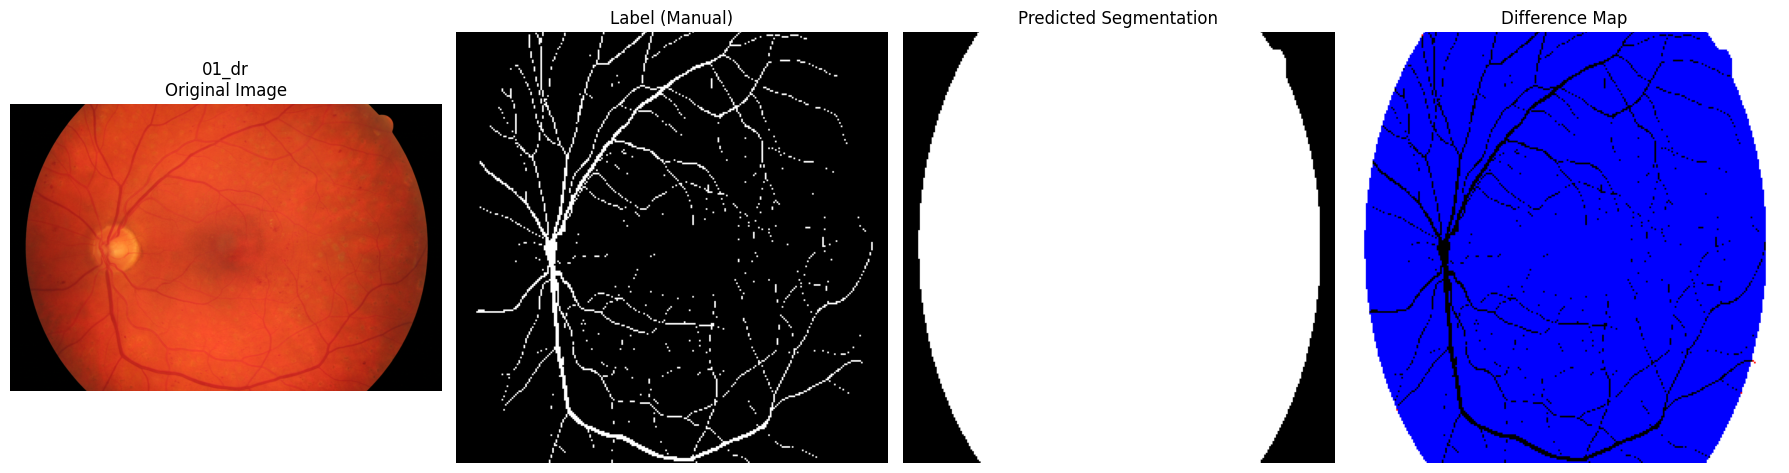

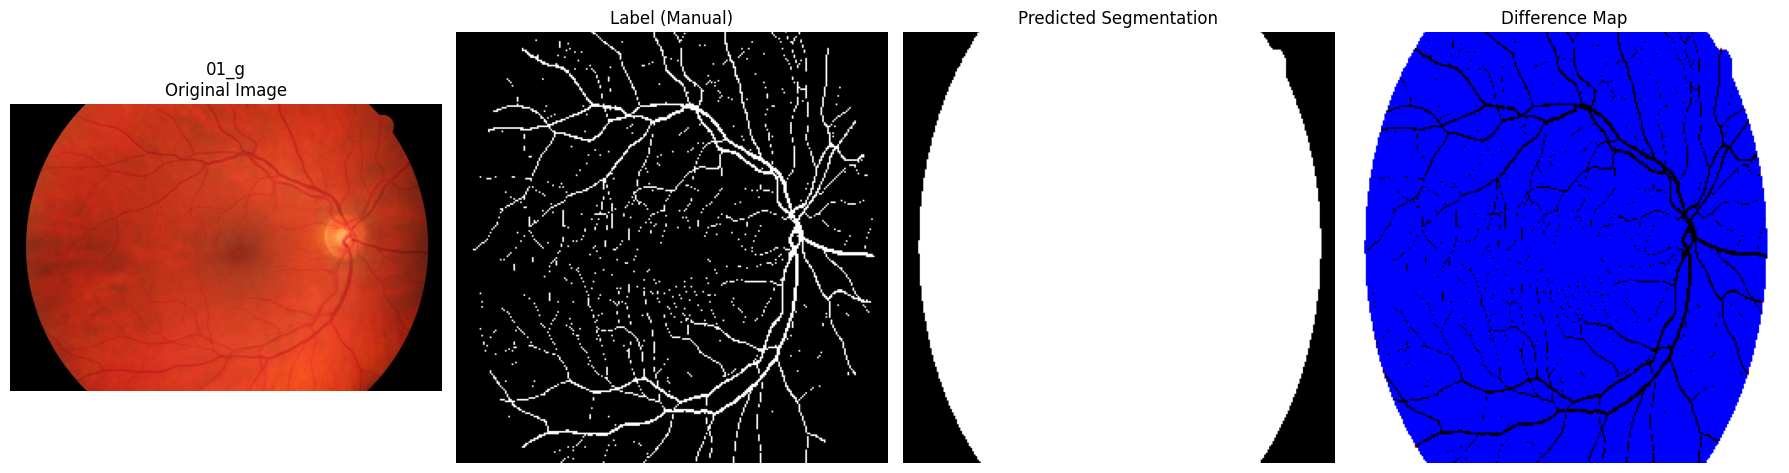

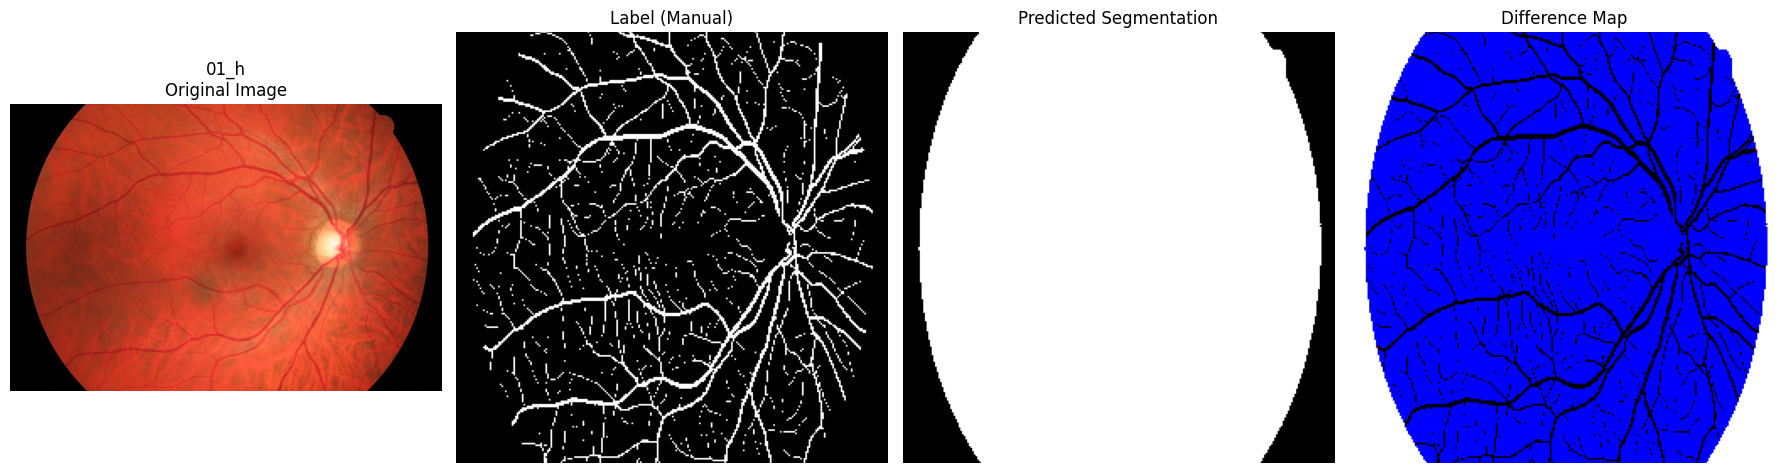

In [ ]:
# Plot results for each image: original, label, predicted segmentation, diff map
for i, (base, result) in enumerate(segmentation_results.items()):
    image = result["image"]
    label = result["label"]
    pred = result["pred"]
    diff_map = Visualisation.create_diffmap(label, pred)
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    axes[0].imshow(image)
    axes[0].set_title(f"{base}\nOriginal Image")
    axes[0].axis('off')
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title("Label (Manual)")
    axes[1].axis('off')
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Predicted Segmentation")
    axes[2].axis('off')
    axes[3].imshow(diff_map)
    axes[3].set_title("Difference Map")
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()

Analyzing 01_dr:
Label stats: min=0, max=255, unique values=[  0 255]
Vessel probability stats: min=0.000, max=1.000, mean=0.841
Mask stats: min=0, max=255, total valid pixels=55355

Within mask region:
  Label pixels: 55355 total
  Vessel pixels in ground truth: 3311 (6.0%)
  Background pixels in ground truth: 52044 (94.0%)
  Average vessel probability: 0.995

Target vessel ratio from ground truth: 0.060

Testing different thresholds:
  Threshold 0.1: 55339 vessel pixels (1.000 ratio), diff from target: 0.940
  Threshold 0.2: 55322 vessel pixels (0.999 ratio), diff from target: 0.940
  Threshold 0.3: 55310 vessel pixels (0.999 ratio), diff from target: 0.939
  Threshold 0.4: 55284 vessel pixels (0.999 ratio), diff from target: 0.939
  Threshold 0.5: 55267 vessel pixels (0.998 ratio), diff from target: 0.939
  Threshold 0.6: 55252 vessel pixels (0.998 ratio), diff from target: 0.938
  Threshold 0.7: 55226 vessel pixels (0.998 ratio), diff from target: 0.938
  Threshold 0.8: 55206 vesse

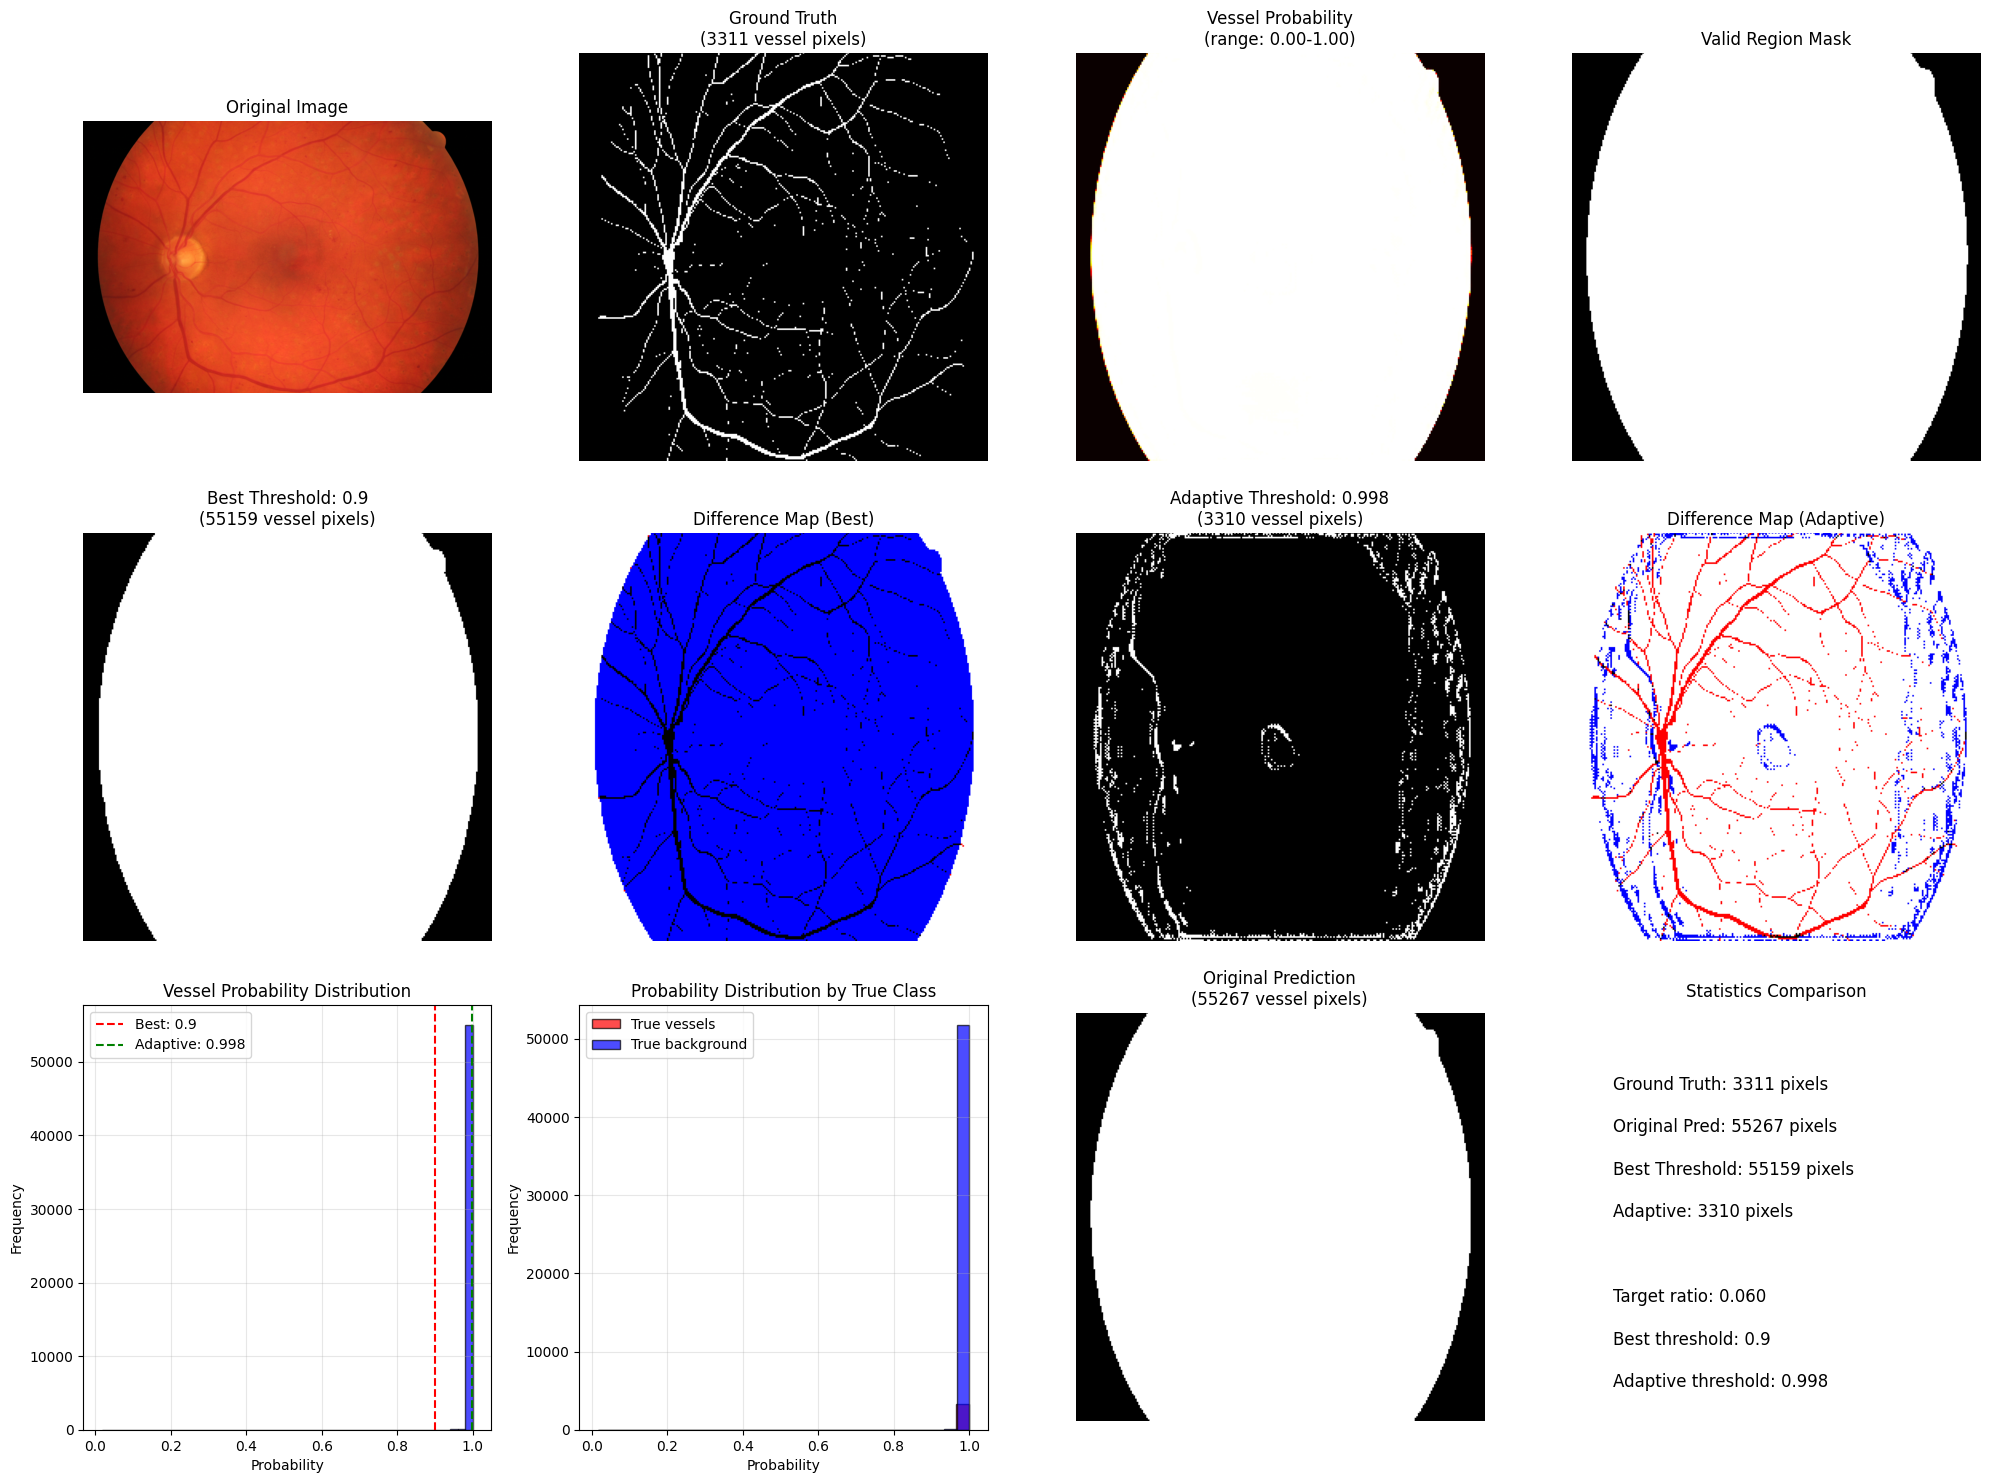


Updated segmentation results with better thresholds.
Use 'pred_adaptive' for best results matching ground truth ratio.


In [ ]:
# Detailed analysis of why predictions are all white
import matplotlib.pyplot as plt
import numpy as np

if segmentation_results:
    # Take the first image for detailed analysis
    base, result = next(iter(segmentation_results.items()))
    image = result["image"]
    label = result["label"]
    vessel_prob = result["vessel_prob"]
    mask = result["mask"]
    
    print(f"Analyzing {base}:")
    print(f"Label stats: min={label.min()}, max={label.max()}, unique values={np.unique(label)}")
    print(f"Vessel probability stats: min={vessel_prob.min():.3f}, max={vessel_prob.max():.3f}, mean={vessel_prob.mean():.3f}")
    print(f"Mask stats: min={mask.min()}, max={mask.max()}, total valid pixels={np.sum(mask > 0)}")
    print()
    
    # Check label statistics within mask
    label_in_mask = label[mask > 0]
    vessel_prob_in_mask = vessel_prob[mask > 0]
    print(f"Within mask region:")
    print(f"  Label pixels: {len(label_in_mask)} total")
    print(f"  Vessel pixels in ground truth: {np.sum(label_in_mask > 0)} ({100*np.sum(label_in_mask > 0)/len(label_in_mask):.1f}%)")
    print(f"  Background pixels in ground truth: {np.sum(label_in_mask == 0)} ({100*np.sum(label_in_mask == 0)/len(label_in_mask):.1f}%)")
    print(f"  Average vessel probability: {vessel_prob_in_mask.mean():.3f}")
    print()
    
    # Test multiple thresholds and find the one that matches ground truth ratio
    target_vessel_ratio = np.sum(label_in_mask > 0) / len(label_in_mask)
    print(f"Target vessel ratio from ground truth: {target_vessel_ratio:.3f}")
    
    thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    best_threshold = 0.5
    best_diff = float('inf')
    
    print("\nTesting different thresholds:")
    for thresh in thresholds_to_test:
        pred_thresh = (vessel_prob > thresh).astype(np.uint8)
        pred_in_mask = pred_thresh[mask > 0]
        pred_vessel_ratio = np.sum(pred_in_mask > 0) / len(pred_in_mask)
        diff = abs(pred_vessel_ratio - target_vessel_ratio)
        
        print(f"  Threshold {thresh:.1f}: {np.sum(pred_in_mask > 0)} vessel pixels ({pred_vessel_ratio:.3f} ratio), diff from target: {diff:.3f}")
        
        if diff < best_diff:
            best_diff = diff
            best_threshold = thresh
    
    print(f"\nBest threshold: {best_threshold} (closest to ground truth ratio)")
    
    # Create visualization with the best threshold
    best_pred = (vessel_prob > best_threshold).astype(np.uint8)
    best_pred_masked = np.zeros_like(best_pred)
    best_pred_masked[mask > 0] = best_pred[mask > 0]
    
    # Also try adaptive threshold based on percentiles
    vessel_prob_sorted = np.sort(vessel_prob_in_mask)[::-1]  # Sort descending
    target_pixels = int(target_vessel_ratio * len(vessel_prob_in_mask))
    if target_pixels > 0 and target_pixels < len(vessel_prob_sorted):
        adaptive_threshold = vessel_prob_sorted[target_pixels]
        print(f"Adaptive threshold (based on percentile): {adaptive_threshold:.3f}")
        
        adaptive_pred = (vessel_prob > adaptive_threshold).astype(np.uint8)
        adaptive_pred_masked = np.zeros_like(adaptive_pred)
        adaptive_pred_masked[mask > 0] = adaptive_pred[mask > 0]
    else:
        adaptive_pred_masked = best_pred_masked
        adaptive_threshold = best_threshold
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Row 1: Original data
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(label, cmap='gray')
    axes[0, 1].set_title(f'Ground Truth\n({np.sum(label_in_mask > 0)} vessel pixels)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(vessel_prob, cmap='hot', vmin=0, vmax=1)
    axes[0, 2].set_title(f'Vessel Probability\n(range: {vessel_prob.min():.2f}-{vessel_prob.max():.2f})')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(mask, cmap='gray')
    axes[0, 3].set_title('Valid Region Mask')
    axes[0, 3].axis('off')
    
    # Row 2: Best threshold results
    axes[1, 0].imshow(best_pred_masked, cmap='gray')
    axes[1, 0].set_title(f'Best Threshold: {best_threshold}\n({np.sum(best_pred_masked > 0)} vessel pixels)')
    axes[1, 0].axis('off')
    
    diff_map_best = Visualisation.create_diffmap(label, best_pred_masked)
    axes[1, 1].imshow(diff_map_best)
    axes[1, 1].set_title('Difference Map (Best)')
    axes[1, 1].axis('off')
    
    # Row 3: Adaptive threshold results
    axes[1, 2].imshow(adaptive_pred_masked, cmap='gray')
    axes[1, 2].set_title(f'Adaptive Threshold: {adaptive_threshold:.3f}\n({np.sum(adaptive_pred_masked > 0)} vessel pixels)')
    axes[1, 2].axis('off')
    
    diff_map_adaptive = Visualisation.create_diffmap(label, adaptive_pred_masked)
    axes[1, 3].imshow(diff_map_adaptive)
    axes[1, 3].set_title('Difference Map (Adaptive)')
    axes[1, 3].axis('off')
    
    # Row 3: Probability distribution analysis
    axes[2, 0].hist(vessel_prob_in_mask, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[2, 0].axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold}')
    axes[2, 0].axvline(adaptive_threshold, color='green', linestyle='--', label=f'Adaptive: {adaptive_threshold:.3f}')
    axes[2, 0].set_title('Vessel Probability Distribution')
    axes[2, 0].set_xlabel('Probability')
    axes[2, 0].set_ylabel('Frequency')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    # Show vessel probability only in vessel regions from ground truth
    vessel_regions = label > 0
    if np.sum(vessel_regions) > 0:
        vessel_prob_in_vessels = vessel_prob[vessel_regions & (mask > 0)]
        background_prob_in_vessels = vessel_prob[~vessel_regions & (mask > 0)]
        
        axes[2, 1].hist(vessel_prob_in_vessels, bins=30, alpha=0.7, color='red', label='True vessels', edgecolor='black')
        axes[2, 1].hist(background_prob_in_vessels, bins=30, alpha=0.7, color='blue', label='True background', edgecolor='black')
        axes[2, 1].set_title('Probability Distribution by True Class')
        axes[2, 1].set_xlabel('Probability')
        axes[2, 1].set_ylabel('Frequency')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
    else:
        axes[2, 1].text(0.5, 0.5, 'No vessel regions found', ha='center', va='center')
        axes[2, 1].set_title('Probability Distribution by True Class')
    
    # Show original prediction (probably all white)
    original_pred = result['pred']
    axes[2, 2].imshow(original_pred, cmap='gray')
    axes[2, 2].set_title(f'Original Prediction\n({np.sum(original_pred > 0)} vessel pixels)')
    axes[2, 2].axis('off')
    
    # Show comparison
    axes[2, 3].text(0.1, 0.8, f'Ground Truth: {np.sum(label_in_mask > 0)} pixels', fontsize=12)
    axes[2, 3].text(0.1, 0.7, f'Original Pred: {np.sum(original_pred > 0)} pixels', fontsize=12)
    axes[2, 3].text(0.1, 0.6, f'Best Threshold: {np.sum(best_pred_masked > 0)} pixels', fontsize=12)
    axes[2, 3].text(0.1, 0.5, f'Adaptive: {np.sum(adaptive_pred_masked > 0)} pixels', fontsize=12)
    axes[2, 3].text(0.1, 0.3, f'Target ratio: {target_vessel_ratio:.3f}', fontsize=12)
    axes[2, 3].text(0.1, 0.2, f'Best threshold: {best_threshold}', fontsize=12)
    axes[2, 3].text(0.1, 0.1, f'Adaptive threshold: {adaptive_threshold:.3f}', fontsize=12)
    axes[2, 3].set_xlim(0, 1)
    axes[2, 3].set_ylim(0, 1)
    axes[2, 3].set_title('Statistics Comparison')
    axes[2, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Update the segmentation results with better predictions
    segmentation_results[base]['pred'] = adaptive_pred_masked
    segmentation_results[base]['pred_best'] = best_pred_masked
    segmentation_results[base]['pred_adaptive'] = adaptive_pred_masked
    
    print(f"\nUpdated segmentation results with better thresholds.")
    print(f"Use 'pred_adaptive' for best results matching ground truth ratio.")
else:
    print("No segmentation results available for analysis.")